## 3시그마

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# [Step 1] 데이터 생성 (가상 센서 데이터)
# ---------------------------------------------------------
np.random.seed(42) # 결과 재현을 위해 시드 고정

# 정상 데이터: 평균 50, 표준편차 2인 정규분포 100개
dates = pd.date_range('2024-01-01', periods=100, freq='H')
values = np.random.normal(50, 2, 100)

# 데이터프레임 생성
df = pd.DataFrame({'timestamp': dates, 'temperature': values})
df = df.set_index('timestamp')

# ★ 이상치(Anomaly) 강제 주입 (고장 상황 연출)
df.iloc[20] = 60.0  # 상한 돌파 (과열)
df.iloc[50] = 40.0  # 하한 돌파 (냉각)
df.iloc[80] = 58.5  # 상한 근처

/var/folders/bf/_c9d0b9571x410m1fmyxr4yh0000gn/T/ipykernel_6579/3016188719.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range('2024-01-01', periods=100, freq='H')


In [2]:
df

,temperature
timestamp,
2024-01-01 00:00:00,50.993428
2024-01-01 01:00:00,49.723471
2024-01-01 02:00:00,51.295377
2024-01-01 03:00:00,53.046060
2024-01-01 04:00:00,49.531693
...,...
2024-01-04 23:00:00,47.072970
2024-01-05 00:00:00,50.592241
2024-01-05 01:00:00,50.522111


### [Step 2] 3-Sigma 임계값 계산 (핵심 로직)

In [3]:
mean = df['temperature'].mean() # 평균
std = df['temperature'].std() # 표준편차

# 3-Sigma Rule: 평균 ± 3*표준편차
upper_limit = mean + (3 * std)
lower_limit = mean - (3 * std)

print(f"[Threshold] 상한: {upper_limit:.2f}, 하한: {lower_limit:.2f}")

[Threshold] 상한: 57.18, 하한: 42.51


### [Step 3] 이상치 필터링 (Boolean Masking)

In [4]:
# 조건: (상한보다 크거나) OR (하한보다 작거나)
# 주의: Pandas 벡터 연산에서는 'or' 대신 비트연산자 '|' 사용 필수!
mask_anomaly = (df['temperature'] > upper_limit) | (df['temperature'] < lower_limit)

# 이상치 데이터만 추출 (시각화용)
anomalies = df[mask_anomaly]
print(f"\n[Anomaly Detected] 총 {len(anomalies)}건 발견")


[Anomaly Detected] 총 3건 발견


In [5]:
anomalies

,temperature
timestamp,
2024-01-01 20:00:00,60.0
2024-01-03 02:00:00,40.0
2024-01-04 08:00:00,58.5


### [Step 4] 시각화 (Visualization)

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/var/folders/bf/_c9d0b9571x410m1fmyxr4yh0000gn/T/ipykernel_6579/432506817.py:7: SyntaxWarning: invalid escape sequence '\s'
  ax.axhline(upper_limit, color='red', linestyle='--', label='Upper Threshold (3$\sigma$)')
/var/folders/bf/_c9d0b9571x410m1fmyxr4yh0000gn/T/ipykernel_6579/432506817.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.axhline(lower_limit, color='red', linestyle='--', label='Lower Threshold (3$\sigma$)')


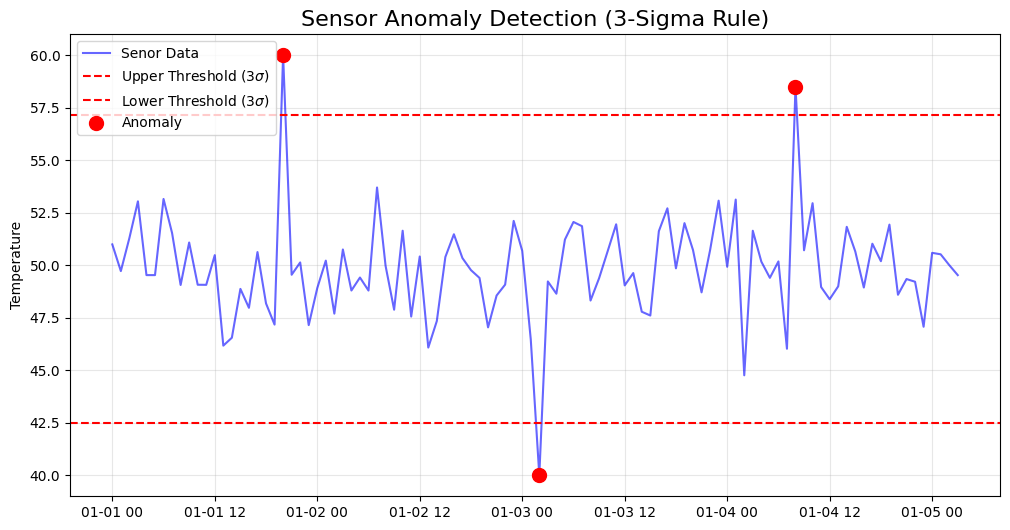

In [6]:
fig, ax = plt.subplots(figsize =(12,6))

# 1. 전체 데이터 (파란 실선)
ax.plot(df.index, df['temperature'],label ='Senor Data', color = 'blue', alpha = 0.6)

# 2. 임계선 (빨간 점선) - axhline 사용
ax.axhline(upper_limit, color='red', linestyle='--', label='Upper Threshold (3$\sigma$)')
ax.axhline(lower_limit, color='red', linestyle='--', label='Lower Threshold (3$\sigma$)')

# 3. 이상치 강조 (빨간 점) - scatter 사용 zorder=5는 겹칠떄 우선순위임. 뭐가 위로 보일지. 5는 사용자 설정같은 느낌.
ax.scatter(x= anomalies.index, y = anomalies['temperature'], color='red', s=100, zorder=5, label='Anomaly') 

# 꾸미기
ax.set_title('Sensor Anomaly Detection (3-Sigma Rule)', fontsize=16)
ax.set_ylabel('Temperature')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


## IQR

In [7]:
# 1. 찌그러진 데이터(Skewed Data) 생성
# lognormal: 왼쪽으로 쏠리고 꼬리가 긴 분포 (소득, 불량률 등 현실 데이터와 유사)
np.random.seed(42)
skewed_data = np.random.lognormal(mean=0, sigma=0.5, size=100) * 10 + 50
df_skew = pd.DataFrame({'timestamp': dates, 'value': skewed_data})
df_skew = df_skew.set_index('timestamp')

# 이상치 주입 (확 티나게)
df_skew.iloc[20] = 100.0  # 극단적 상한
df_skew.iloc[50] = 30.0   # 극단적 하한

print(df_skew)
print("--- Skewed Data Describe ---")
print(df_skew.describe()) # mean과 50%(median) 차이 확인!

                         value
timestamp                     
2024-01-01 00:00:00  62.819176
2024-01-01 01:00:00  59.332033
2024-01-01 02:00:00  63.824320
2024-01-01 03:00:00  71.415180
2024-01-01 04:00:00  58.895170
...                        ...
2024-01-04 23:00:00  54.810628
2024-01-05 00:00:00  61.595826
2024-01-05 01:00:00  61.394294
2024-01-05 02:00:00  60.025600
2024-01-05 03:00:00  58.893241

[100 rows x 1 columns]
--- Skewed Data Describe ---
            value
count  100.000000
mean    60.457459
std      6.819722
min     30.000000
25%     57.362129
50%     59.222761
75%     62.254679
max    100.000000


###  2. IQR 계산 (핵심 로직)

In [8]:
# quantile(0.25) -> 하위 25% (Q1)
# quantile(0.75) -> 상위 25% (Q3)
Q1 = df_skew['value'].quantile(0.25)
Q3 = df_skew['value'].quantile(0.75)
IQR = Q3 - Q1

### 3. 울타리(Fence) 치기 (통상적으로 1.5배 사용)

In [9]:
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)

print(f"\n[IQR Threshold] 상한: {upper_fence:.2f}, 하한: {lower_fence:.2f}")


[IQR Threshold] 상한: 69.59, 하한: 50.02


### 4. 필터링 & 시각화


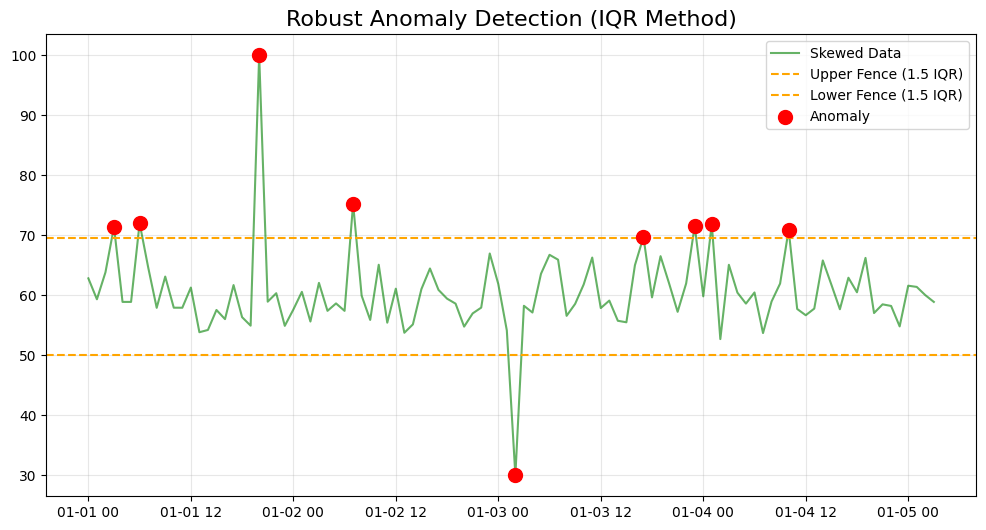

In [ ]:
mask_iqr = (df_skew['value'] > upper_fence) | (df_skew['value'] < lower_fence)
anomalies_iqr = df_skew[mask_iqr]  # anomalies_iqr이건 마스트에 해당하는것만 나타내는거임 

# 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 6))

# (1) 데이터
ax.plot(df_skew.index, df_skew['value'], label='Skewed Data', color='green', alpha=0.6)

# (2) IQR 임계선 (주황색 점선)
ax.axhline(upper_fence, color='orange', linestyle='--', label='Upper Fence (1.5 IQR)')
ax.axhline(lower_fence, color='orange', linestyle='--', label='Lower Fence (1.5 IQR)')

# (3) 이상치 (빨간 점)
ax.scatter(anomalies_iqr.index, anomalies_iqr['value'], color='red', s=100, zorder=5, label='Anomaly')

ax.set_title('Robust Anomaly Detection (IQR Method)', fontsize=16)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

## 시각화 연습

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1) 가상 시계열 데이터 만들기
# -------------------------------
np.random.seed(7)

n = 240  # 4시간(1분 간격)
ts = pd.date_range("2026-02-02 09:00:00", periods=n, freq="1min")

df = pd.DataFrame({
    "ts": np.tile(ts, 2),
    "machine_id": np.repeat(["M01", "M02"], n),
})

# 정상 진동값 생성(머신마다 평균 조금 다르게)
base_m01 = 10 + np.random.normal(0, 0.8, n)
base_m02 = 12 + np.random.normal(0, 0.9, n)

df.loc[df["machine_id"] == "M01", "vibration"] = base_m01
df.loc[df["machine_id"] == "M02", "vibration"] = base_m02

# 이상치(스파이크) 3개씩 주입
spike_idx_m01 = [30, 120, 200]
spike_idx_m02 = [40, 140, 210]

df.loc[(df["machine_id"] == "M01") & (df["ts"].isin(ts[spike_idx_m01])), "vibration"] += 8
df.loc[(df["machine_id"] == "M02") & (df["ts"].isin(ts[spike_idx_m02])), "vibration"] += 9

In [12]:
df

,ts,machine_id,vibration
0,2026-02-02 09:00:00,M01,11.352421
1,2026-02-02 09:01:00,M01,9.627250
2,2026-02-02 09:02:00,M01,10.026256
3,2026-02-02 09:03:00,M01,10.326013
4,2026-02-02 09:04:00,M01,9.368862
...,...,...,...
475,2026-02-02 12:55:00,M02,12.738011
476,2026-02-02 12:56:00,M02,13.064102
477,2026-02-02 12:57:00,M02,10.939346
478,2026-02-02 12:58:00,M02,12.378942


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ts          480 non-null    datetime64[ns]
 1   machine_id  480 non-null    object        
 2   vibration   480 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.4+ KB


In [14]:
df['machine_id'].value_counts()

machine_id
M01    240
M02    240
Name: count, dtype: int64

### 3-sigma 이상치 플래그 만들기 (machine별)

In [ ]:
# 🐚 모델 별로 만들기 위해서는 각각 해주고 transform으로 해줘야함.
mean_by_m = df.groupby('machine_id')['vibration'].transform('mean')
std_by_m = df.groupby('machine_id')['vibration'].transform('std')

upper = mean_by_m + 3 * std_by_m
lower = mean_by_m - 3 * std_by_m

df["is_anom_3sigma"] = (df["vibration"] < lower) | (df["vibration"] > upper)
print(df[df['is_anom_3sigma'] == True])

                     ts machine_id  vibration  is_anom_3sigma
30  2026-02-02 09:30:00        M01  17.405957            True
120 2026-02-02 11:00:00        M01  17.687691            True
200 2026-02-02 12:20:00        M01  16.653283            True
280 2026-02-02 09:40:00        M02  20.471021            True
380 2026-02-02 11:20:00        M02  21.833672            True
450 2026-02-02 12:30:00        M02  20.459026            True


### 시각화 1: 원시 시계열 + 이상치 표시 

In [ ]:
mask_iqr = (df_skew['value'] > upper_fence) | (df_skew['value'] < lower_fence)
anomalies_iqr = df_skew[mask_iqr]  # anomalies_iqr이건 마스트에 해당하는것만 나타내는거임 

# 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 6))

# (1) 데이터
ax.plot(df_skew.index, df_skew['value'], label='Skewed Data', color='green', alpha=0.6)

# (2) IQR 임계선 (주황색 점선)
ax.axhline(upper_fence, color='orange', linestyle='--', label='Upper Fence (1.5 IQR)')
ax.axhline(lower_fence, color='orange', linestyle='--', label='Lower Fence (1.5 IQR)')

# (3) 이상치 (빨간 점)
ax.scatter(anomalies_iqr.index, anomalies_iqr['value'], color='red', s=100, zorder=5, label='Anomaly')

ax.set_title('Robust Anomaly Detection (IQR Method)', fontsize=16)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

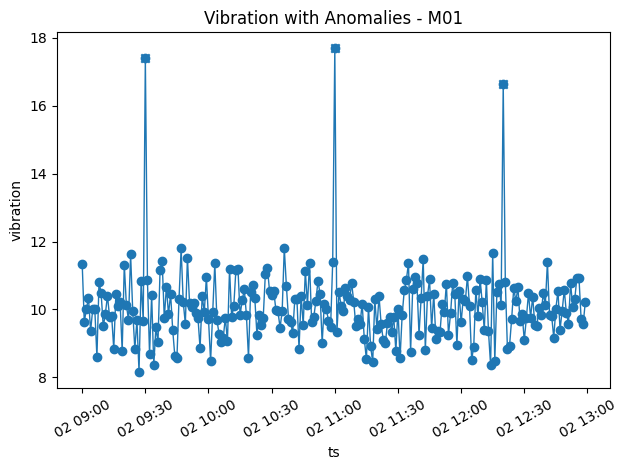

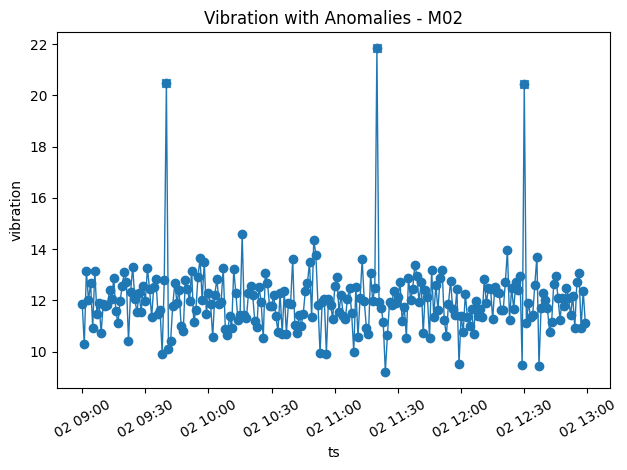

In [24]:
for mid in df["machine_id"].unique():
    sub = df[df["machine_id"] == mid].sort_values("ts")

    plt.figure()
    plt.plot(sub["ts"], sub["vibration"], marker="o", linewidth=1)

    anom = sub[sub["is_anom_3sigma"]]
    plt.scatter(anom["ts"], anom["vibration"], marker="x")

    plt.title(f"Vibration with Anomalies - {mid}")
    plt.xlabel("ts")
    plt.ylabel("vibration")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
